In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess
from scipy.linalg import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
import aesara.tensor as at
from theano.tensor.slinalg import cholesky

starry.config.quiet = True
np.random.seed(1)

In [2]:
# Planet orbit
p_inc = 88.0
p_ecc = 0.2
p_Omega = 100.0
p_w = 30.0
p_porb = 1.0
p_t0 = 0.5
p_r = 0.1

# Star
s_inc = 75
s_u = [0.4, 0.2]
s_prot = 4.3

# Gaussian process for the spots
gp_mu = 30.0
gp_sig = 5.0
gp_r = 10.0
gp_c = 0.1
gp_n = 10.0

# Time array (10 days @ 1 min cadence)
t = np.arange(0, 10, 1 / 24 / 60)

In [3]:
# Get the Cartesian position of the planet
star = starry.Primary(starry.Map())
planet = starry.Secondary(
    starry.Map(),
    inc=p_inc,
    ecc=p_ecc,
    Omega=p_Omega,
    w=p_w,
    porb=p_porb,
    t0=p_t0
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]

In [4]:
# Get the flux design matrix
map = starry.Map(15, len(s_u))
map.inc = s_inc
for n, coeff in enumerate(s_u):
    map[n + 1] = coeff
theta = (360 * t / s_prot) % 360
A = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

In [5]:
A.shape

(14401, 256)

In [6]:
# Draw 10 samples from the GP
sp = StarryProcess(mu=gp_mu, sigma=gp_sig, r=gp_r, c=gp_c, n=gp_n)
y = sp.sample_ylm(nsamples=10).eval().T

In [7]:
# Starry process Ylms are normalized so that they have
# zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
# Let's renormalize it to unity, since that's the baseline
# we want for transits
y[0] += 1

In [8]:
# Compute the light curves
flux0 = (A @ y).T

In [9]:
error = 1e-3
err = np.ones_like(flux0) * error
flux = np.array(flux0)
noise = np.random.randn(len(t)) * err
flux += noise

In [10]:
Sigma_s = sp.cov_ylm
# Sigma = A @ Sigma_s.eval() @ np.transpose(A)
# Sigma += err[0]**2*np.eye(len(t))
Sigma_d = err[0]**2*np.eye(len(t))

In [11]:
# logdet2piSigma = np.linalg.slogdet(2*np.pi*Sigma_s.eval())[1] - np.linalg.slogdet(Sigma_s.eval() @ A.T @ np.linalg.inv(Sigma_d) @ A + np.identity(256))[1]

In [12]:
# nu = np.linalg.inv(Sigma_s.eval() @ A.T @ np.linalg.inv(Sigma_d) @ A + np.identity(256)) @ (Sigma_s.eval() @ A.T @ np.linalg.inv(Sigma_d) @ flux[0] + sp.mean_ylm.eval())

In [13]:
# logLzero = -0.5 * ((d - A @ nu).T @ np.linalg.inv(Sigma_d) @ (d - A @ nu) + (sp.mean_ylm.eval() - y[:,0]).T @ np.linalg.inv(Sigma_s.eval()) @ (sp.mean_ylm.eval() - y[:,0]))

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [14]:
sigmad_inv = 1/np.square(err[0])*np.eye(len(t))

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

In [15]:
# Compute the marginal likelihood
U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[0][:,None])))
log_sigmadet = 2*tt.sum(tt.log(err[0])) + pmm.logdet(U) 
K = len(t)
mean = tt.dot(A,sp.mean_ylm) + 1
r = tt.as_tensor_variable(flux[0]) - mean
M = 1.
v = tt.dot(A.T,(r/tt.square(err[0])))
Q = tt.sum(tt.square(r/err[0])) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
loglike = -0.5 * Q
loglike -= 0.5 * M * log_sigmadet
loglike -= 0.5 * K * M * tt.log(2 * np.pi)

In [16]:
Q.eval()

array(133185.07103909)

In [17]:
loglike.eval()

array(19547.56350103)

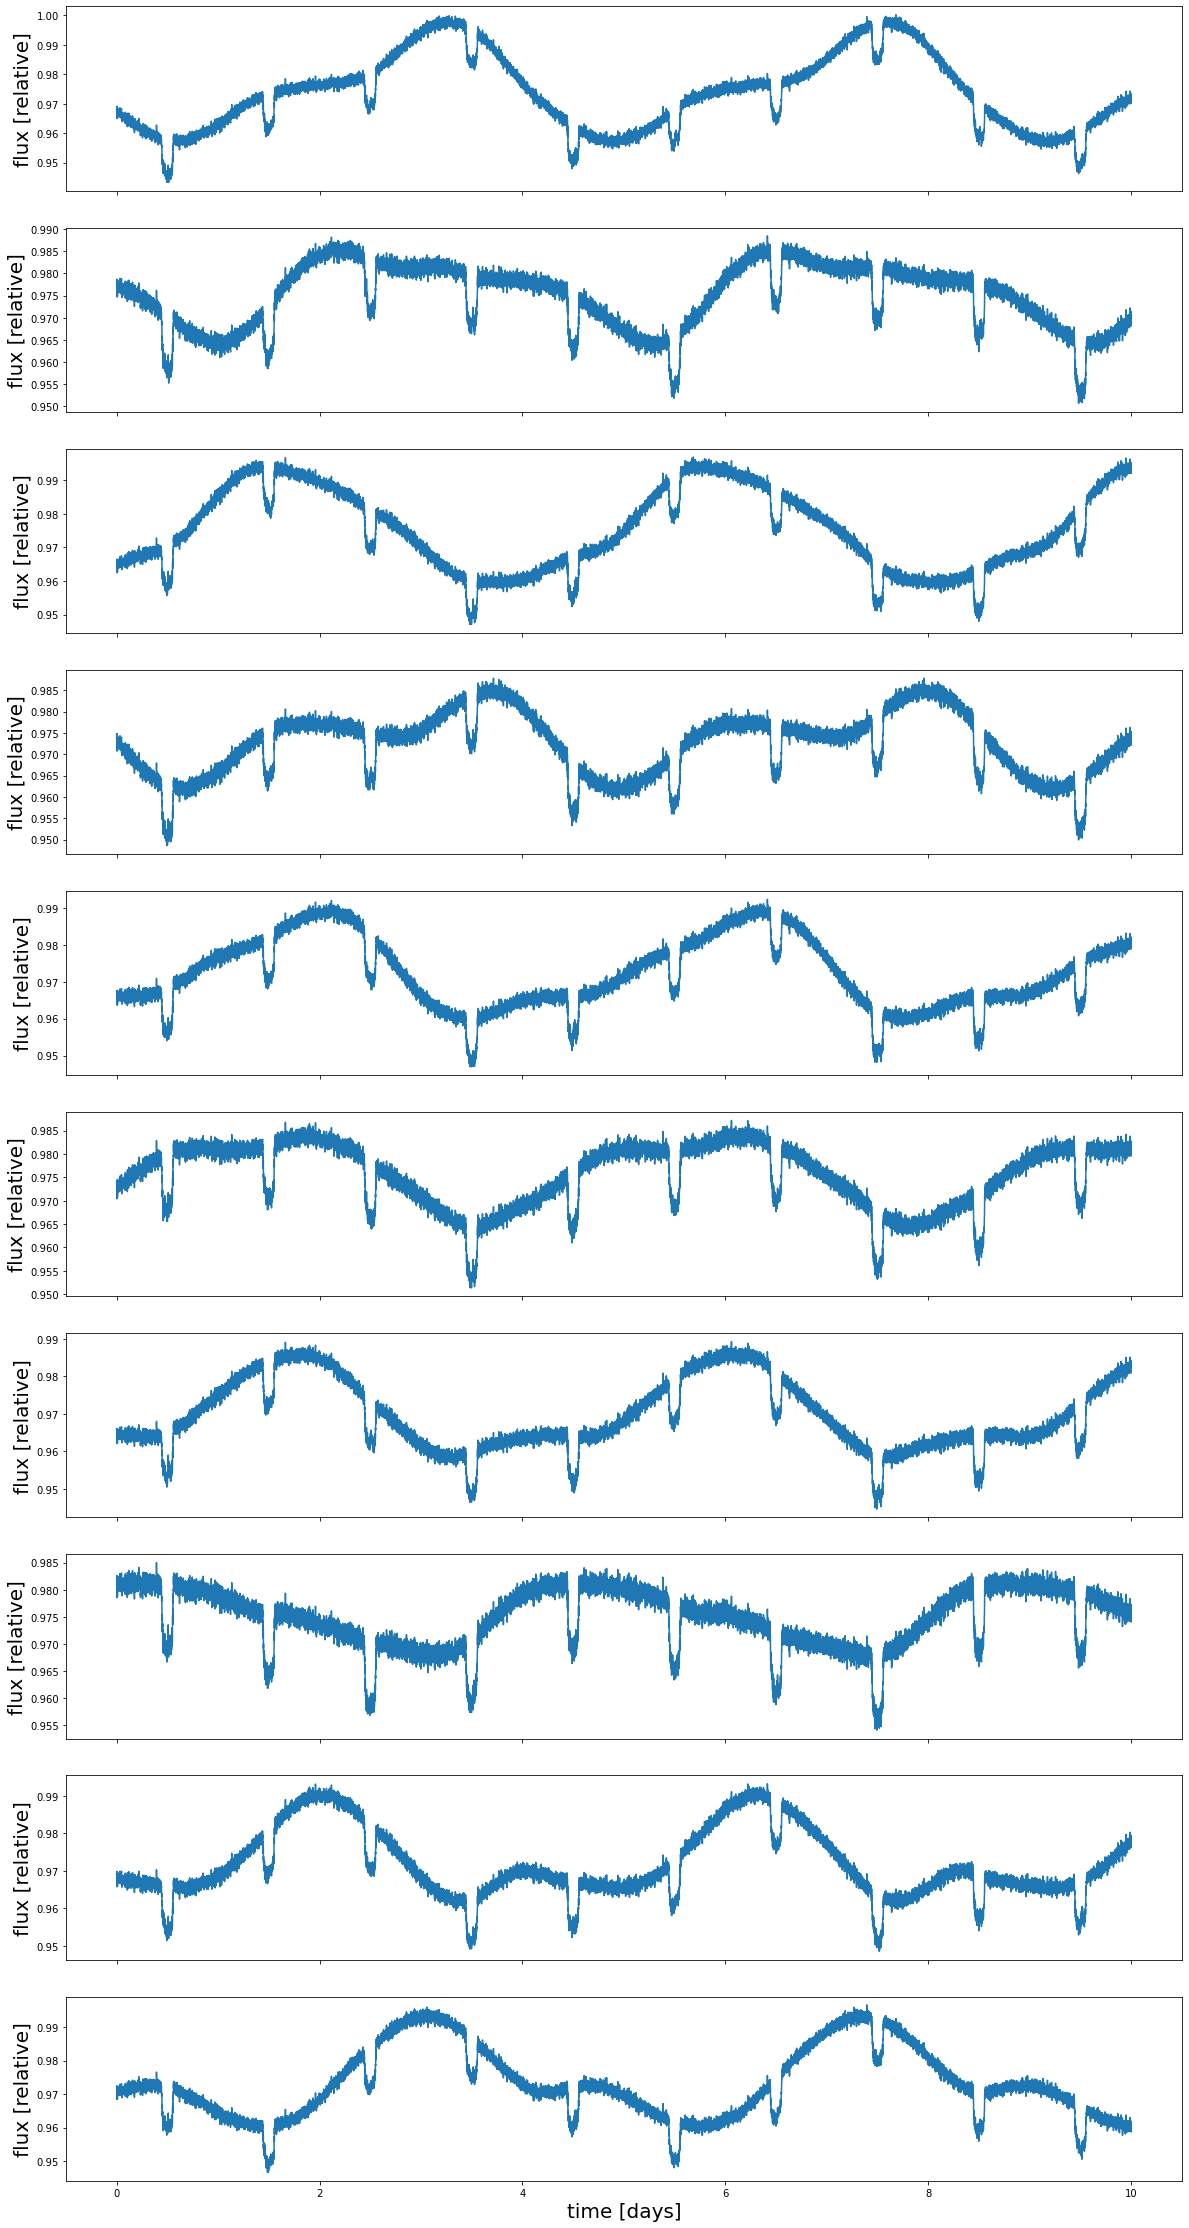

In [18]:
# Plot them
fig, ax = plt.subplots(10, figsize=(20, 40), sharex=True)
for n in range(len(flux)):
    ax[n].plot(t, flux[n])
    ax[n].set_ylabel("flux [relative]", fontsize=20)
ax[-1].set_xlabel("time [days]", fontsize=20);

# Computing the marginal likelihood

In [42]:
from starry_process.math import cho_factor,cho_solve
starry.config.lazy = True
with pm.Model() as model:
    # Params for the flux model
    # Orbital parameters for the planet.
    # porb = pm.Normal("porb", mu=1.0, sigma=0.001)
    # t0 = pm.Normal("t0", mu=0.5, sigma=0.01)
    # u1 = pm.Uniform("u1", lower=0.39, upper=0.41)
    # u2 = pm.Uniform("u2", lower=0.19, upper=0.21)
    rp = pm.Uniform("rp", lower=0.09, upper=0.11)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly, ecept for the limb-darkening coefficients
    star = starry.Primary(starry.Map())
    planet = starry.Secondary(
        starry.Map(),
        inc=p_inc,
        ecc=p_ecc,
        Omega=p_Omega,
        w=p_w,
        porb=p_porb,
        t0=p_t0
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    map = starry.Map(15, len(s_u))
    map.inc = s_inc
    for n, coeff in enumerate(s_u):
        map[n + 1] = coeff
    theta = (360 * t / s_prot) % 360
    A = map.design_matrix(theta=theta, xo=xo[0], yo=yo[0], zo=zo[0], ro=rp)

    mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

    # flux_model = pm.Deterministic(
    #         "flux_model", (sys.flux(t)-1)*1e3
    #     )

    # Things we know
    # u = [u1,u2]

    # Spot latitude params. Isotropic prior on the mode
    # and uniform prior on the standard deviation
    unif0 = pm.Uniform("unif0", 0.0, 1.0)
    mu = 90 - tt.arccos(unif0) * 180 / np.pi
    pm.Deterministic("mu", mu)
    sigma = pm.Uniform("sigma", 1.0, 10.0)

    # Spot radius (uniform prior)
    rs = pm.Uniform("r", 10.0, 30.0)

    # Spot contrast & number of spots (uniform prior)
    c = pm.Uniform("c", 0.0, 0.2, testval=0.1)
    n = pm.Uniform("n", 1.0, 20.0, testval=10)

    # Inclination (isotropic prior)
    unif1 = pm.Uniform("unif1", 0.0, 1.0)
    i = tt.arccos(unif1) * 180 / np.pi
    pm.Deterministic("i", i)

    # Period (uniform prior)
    p = pm.Uniform("p", 0.75, 1.25)

    # Variability timescale (uniform prior)
    tau = pm.Uniform("tau", 0.1, 10.0)

    # # Instantiate the GP
    sp = StarryProcess(mu=mu, sigma=sigma, r=rs, c=c, n=n)

    # Compute the log likelihood
    # Cov matrix at the ylm basis
    Sigma_s = sp.cov_ylm

    # Cov matrix
    # Sigma+=1 # adding the baseline
    Sigma_d = tt.as_tensor_variable(err[0]**2*np.eye(len(t))) # add error to the covariance to make it positive definite
    sigmad_inv = 1/err[0]**2*np.eye(len(t))
    

    # Compute the marginal likelihood
    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[0][:,None])))
    log_sigmadet = 2*tt.sum(tt.log(err[0])) + pmm.logdet(U) 
    K = len(t)
    mean1 = tt.dot(A,sp.mean_ylm) + 1
    r = tt.as_tensor_variable(flux[0]) - mean1
    v = tt.dot(A.T,(r/tt.square(err[0])))
    Q = tt.sum(tt.square(r/err[0])) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    lnlikemod = -0.5 * Q
    lnlikemod -= 0.5 * log_sigmadet
    lnlikemod -= 0.5 * K * tt.log(2 * np.pi)

    pm.Potential("lnlike", lnlikemod)

In [43]:
with model:
    loglike = pmx.eval_in_model(model['lnlike'])

In [44]:
with model:
    c1 = pmx.eval_in_model(model['c'])
    n1 = pmx.eval_in_model(model['n'])
    mu1 = pmx.eval_in_model(model['mu'])

In [45]:
c1

array(0.1)

In [39]:
mu1

array(30.)

In [40]:
n1

array(10.)

In [41]:
loglike

array(8277.93327698)

In [84]:
# Optimize the MAP solution.
with model:
    map_soln = pmx.optimize(start=[gp_n,gp_c,gp_r,gp_mu])

AttributeError: 'list' object has no attribute 'update'

In [47]:
map_soln['c']

array(0.19988811)

In [48]:
map_soln['rp']

array(0.09000008)

In [49]:
map_soln['mu']

array(14.52345174)

In [50]:
map_soln['sigma']

array(9.99794482)

In [51]:
map_soln['n']

array(9.39250374)

In [52]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp]


/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 36 tune and 0 draw iterations (36 + 0 draws total) took 5716 seconds.
No posterior samples. Unable to run convergence checks


In [ ]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp", "u2", "u1", "t0", "porb"])

In [ ]:
import arviz as az
with model:
    _ = az.plot_trace(trace, var_names=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp", "u2", "u1", "t0", "porb"])

## Binned data

In [54]:
a = p_porb**(2/3) # semi-major axis
b = a*np.cos(p_inc)/1. # impact parameter

In [71]:
shifted = t-p_t0+0.06 # I tuned this parameter a little 
duration = p_porb/np.pi*np.arcsin(np.sqrt((1+p_r)**2-b**2)/a) 
# find all values >= target and < target + duration, modulo period
idx = (shifted >= 0) & (shifted % p_porb <= duration)
idx

array([False, False, False, ..., False, False, False])

In [72]:
# General function to bin the out-of-transit data
import scipy
def bin_lc(x,y,mask):
    num_bins = x[~mask].shape[0] // 10
    binned_means, bin_edges, binnumber = scipy.stats.binned_statistic(
        x[~mask], y[~mask], statistic="mean", bins=num_bins
    )
    bin_width = bin_edges[1] - bin_edges[0]
    x_binned = bin_edges[1:] - bin_width / 2
    
    x_merged = np.concatenate((x_binned, x[mask]))
    y_merged = np.concatenate((binned_means, y[mask]))
    order = x_merged.argsort()
    x_merged = x_merged[order]
    y_merged = y_merged[order]

    x_merged=x_merged[~np.isnan(y_merged)]
    y_merged=y_merged[~np.isnan(y_merged)]

    return x_merged,y_merged

In [73]:
t_binned,y_binned = bin_lc(t,flux[0],idx)

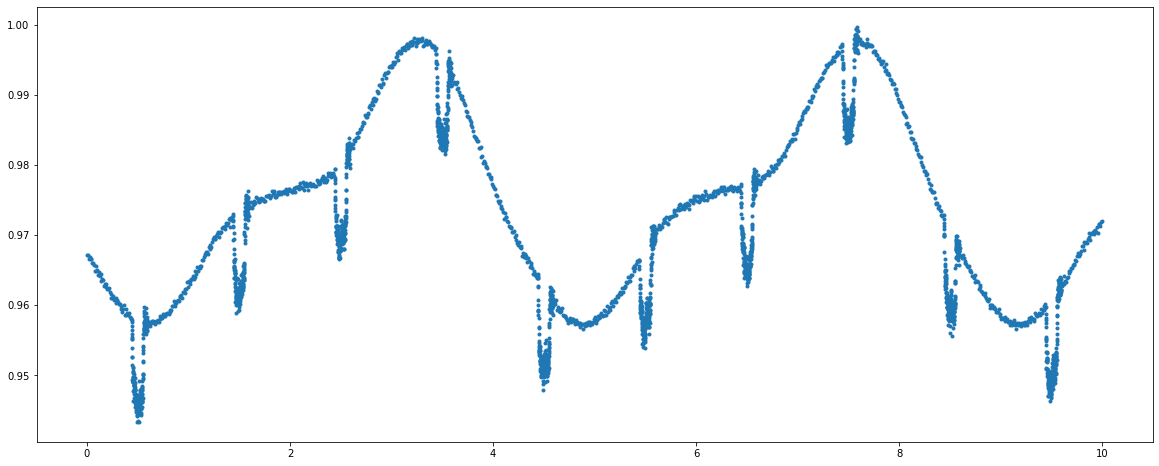

In [74]:
plt.figure(figsize=(20,8))
plt.plot(t_binned, y_binned, '.')

In [88]:
from starry_process.math import cho_factor,cho_solve
starry.config.lazy = True
with pm.Model() as model:
    # Params for the flux model
    # Orbital parameters for the planet.
    # porb = pm.Normal("porb", mu=1.0, sigma=0.001)
    # t0 = pm.Normal("t0", mu=0.5, sigma=0.01)
    # u1 = pm.Uniform("u1", lower=0.39, upper=0.41)
    # u2 = pm.Uniform("u2", lower=0.19, upper=0.21)
    rp = pm.Uniform("rp", lower=0.09, upper=0.11)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly, ecept for the limb-darkening coefficients
    star = starry.Primary(starry.Map())
    planet = starry.Secondary(
        starry.Map(),
        inc=p_inc,
        ecc=p_ecc,
        Omega=p_Omega,
        w=p_w,
        porb=p_porb,
        t0=p_t0
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t_binned)

    # Get the flux design matrix
    map = starry.Map(15, len(s_u))
    map.inc = s_inc
    for n, coeff in enumerate(s_u):
        map[n + 1] = coeff
    theta = (360 * t_binned / s_prot) % 360
    A = map.design_matrix(theta=theta, xo=xo[0], yo=yo[0], zo=zo[0], ro=rp)

    mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

    # flux_model = pm.Deterministic(
    #         "flux_model", (sys.flux(t)-1)*1e3
    #     )

    # Things we know
    # u = [u1,u2]

    # Spot latitude params. Isotropic prior on the mode
    # and uniform prior on the standard deviation
    unif0 = pm.Uniform("unif0", 0.0, 1.0)
    mu = 90 - tt.arccos(unif0) * 180 / np.pi
    pm.Deterministic("mu", mu)
    sigma = pm.Uniform("sigma", 1.0, 10.0)

    # Spot radius (uniform prior)
    rs = pm.Uniform("r", 10.0, 30.0)

    # Spot contrast & number of spots (uniform prior)
    c = pm.Uniform("c", 0.0, 0.2, testval=0.1)
    n = pm.Uniform("n", 1.0, 20.0, testval=10)

    # Inclination (isotropic prior)
    unif1 = pm.Uniform("unif1", 0.0, 1.0)
    i = tt.arccos(unif1) * 180 / np.pi
    pm.Deterministic("i", i)

    # Period (uniform prior)
    p = pm.Uniform("p", 0.75, 1.25)

    # Variability timescale (uniform prior)
    tau = pm.Uniform("tau", 0.1, 10.0)

    # # Instantiate the GP
    sp = StarryProcess(mu=mu, sigma=sigma, r=rs, c=c, n=n)

    # Compute the log likelihood
    # Cov matrix at the ylm basis
    Sigma_s = sp.cov_ylm

    # Cov matrix
    error = 1e-3/np.sqrt(len(t_binned))
    err = np.ones_like(y_binned) * error
    # Sigma+=1 # adding the baseline
    Sigma_d = tt.as_tensor_variable(err**2*np.eye(len(t_binned))) # add error to the covariance to make it positive definite
    sigmad_inv = 1/err**2*np.eye(len(t_binned))
    

    # Compute the marginal likelihood
    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))
    log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
    K = len(t)
    mean1 = tt.dot(A,sp.mean_ylm) + 1
    r = tt.as_tensor_variable(y_binned) - mean1
    v = tt.dot(A.T,(r/tt.square(err)))
    Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
    lnlikemod = -0.5 * Q
    lnlikemod -= 0.5 * log_sigmadet
    lnlikemod -= 0.5 * K * tt.log(2 * np.pi)

    pm.Potential("lnlike", lnlikemod)

In [89]:
with model:
    loglike = pmx.eval_in_model(model['lnlike'])

In [90]:
loglike

array(-67754850.9780272)

In [91]:
# Optimize the MAP solution.
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp]


message: Desired error not necessarily achieved due to precision loss.
logp: -67754866.49917851 -> -64462257.25570022


In [92]:
map_soln['n']

array(19.94582074)

In [93]:
map_soln['c']

array(0.19892485)

In [94]:
map_soln['mu']

array(23.46762164)

In [95]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp]


Sampling 1 chain for 250 tune and 146 draw iterations (250 + 146 draws total) took 40992 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
